In [1]:
'''
Building on top of neural_networks_test.ipynb
AS 4 BUT WITH MORE WINDOWS TAKEN IN CONSIDERATION. 
100 CYCLES PER WINDOW AS USUAL, BUT 100 WINDOWS PER CELL 
(DYNAMIC "STRIDE" IN DEFINING THE DATASET)
'''
import sys
import os
sys.path.insert(0, '/home/viscio/WORK/battery_lifetime')

In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [3]:
%matplotlib inline

In [4]:
from numpy.random import seed
from tensorflow import set_random_seed
seed(42)
set_random_seed(42)

In [5]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor

In [7]:
import keras
import keras.backend as kb
from keras import initializers
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, ELU, ReLU
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers
from keras.layers import Dense, SimpleRNN, GRU, LSTM
from keras.models import Input, Model
from keras.layers import TimeDistributed
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [8]:
import tensorflow as tf

In [9]:
from utilities import split_df, get_xy, get_xy_scaled, apply_model

In [10]:
# this is used to cache the memory to prevent redoing some 
# heavy computations - mainly weights training
from joblib import Memory
memory = Memory(cachedir='cache')

In [11]:
from keras import backend as K
import tensorflow as tf
NUM_PARALLEL_EXEC_UNITS = 8
config = tf.ConfigProto(intra_op_parallelism_threads=NUM_PARALLEL_EXEC_UNITS, 
                        inter_op_parallelism_threads=2,
                        allow_soft_placement=True, 
                        device_count={'CPU': NUM_PARALLEL_EXEC_UNITS})
session = tf.Session(config=config)
K.set_session(session)
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["KMP_BLOCKTIME"] = "30"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"] = "granularity=fine,verbose,compact,1,0"

In [12]:
# Read the data from file
dfs = pd.read_hdf('/home/viscio/WORK/battery_lifetime/data/processed_data/battery_summary_data.h5')

In [13]:
dfs.head()

IR   QCharge  QDischarge       Tavg       Tmax  \
cell_id cycle                                                         
0       1      0.016742  1.071042    1.070689  31.875011  35.652016   
        2      0.016724  1.071674    1.071900  31.931490  35.692978   
        3      0.016681  1.072304    1.072510  31.932603  35.680588   
        4      0.016662  1.072970    1.073174  31.959322  35.728691   
        5      0.016623  1.073491    1.073576  31.961062  35.711758   

                    Tmin  chargetime     RUL            DQ  
cell_id cycle                                               
0       1      29.566130   13.341250  1849.0  0.000000e+00  
        2      29.604385   13.425777  1848.0  4.958155e-07  
        3      29.744202   13.425167  1847.0  1.964282e-06  
        4      29.644709   13.341442  1846.0  2.166772e-06  
        5      29.752932   13.340835  1845.0  4.674332e-06

In [14]:
# Columns to drop
drop_columns = ['RUL', 'chargetime']

In [15]:
# Define R2 metric (1-(SS_res/SS-tot))
# SS_res = sum(y-y_pred)^2
# SS_tot = sum(y-y_mean)^2
def r2_metric(y_true, y_pred):
    y_true = tf.convert_to_tensor(y_true, np.float32)
    y_pred = tf.convert_to_tensor(y_pred, np.float32)
    SS_res = kb.sum(kb.square(y_true - y_pred))
    SS_tot = kb.sum(kb.square(y_true - kb.mean(y_true)))
    return kb.eval((1 - SS_res / (SS_tot + kb.epsilon())))

In [16]:
# Define root mean squared metric
def root_mean_squared_error(y_true, y_pred):
        return kb.sqrt(kb.mean(kb.square(y_pred - y_true))) 

In [17]:
# Number of cycles to use for prediction
n_cycles = 100
#number of features
n_features = dfs.drop(columns=drop_columns).columns.shape[0]

In [18]:
# Let's try to clean the data, since there are a lot of spikes that probably
# represent some error in the sensor reading. 
# We employ Exponential Moving Averages in order to "smoothen out" the problematic curves. 
ir = []
qcharge = []
qdischarge = []
dq = []

for i in dfs.index.levels[0]:
    ewm_ir = dfs.loc[(i, slice(None)),'IR'].ewm(span=5,adjust=False).mean().values
    ewm_qc = dfs.loc[(i, slice(None)),'QCharge'].ewm(span=5,adjust=False).mean().values
    ewm_qd = dfs.loc[(i, slice(None)),'QDischarge'].ewm(span=5,adjust=False).mean().values
    ewm_dq = dfs.loc[(i, slice(None)),'DQ'].ewm(span=5,adjust=False).mean().values
    ir = np.concatenate((ir, ewm_ir), axis=None)
    qcharge = np.concatenate((qcharge, ewm_qc), axis=None)
    qdischarge = np.concatenate((qdischarge, ewm_qd), axis=None)
    dq = np.concatenate((dq, ewm_dq), axis=None)


dfs['IR'] = ir
dfs['QCharge'] = qcharge
dfs['QDischarge'] = qdischarge
dfs['DQ'] = dq

In [37]:
# The idea is to use a RNN to predict what happens at later cycles.
# Get "windows" of 100 cycles from ALL the cycles in a cell as your whole data. 
# We take 100 possible windows per battery. 
# Treat this as a number of time-series, each with n_features features (all except RUL)
# The data then needs to be organized as such: (batch_size, timesteps, features)
# and needs to maintain the time-ordering of the sequence. 

X = []
y = []

for i in dfs.index.levels[0]:
    tot_cycles = len(dfs.loc[(i, slice(None)),'DQ'].values)-n_cycles
    shift = (tot_cycles - n_cycles)//100
    for j in range(0, tot_cycles, shift):
        X.append(dfs.loc[(i, slice(j+1,n_cycles+j)), :].drop(columns=drop_columns).values)
        y.append(dfs.loc[(i, n_cycles+j), :].RUL)

X = np.array(X)
y = np.array(y)

print('Input array shape: ', X.shape)

# Split in train/test sets. The data is also randomply selected
# and this is important, since the daa is ordered - by construction.
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33)

print('batch size, timesteps, features')
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test ', X_test.shape)
print('y_test ', y_test.shape)

Input array shape:  (16958, 100, 7)
batch size, timesteps, features
X_train (11361, 100, 7)
y_train (11361,)
X_test  (5597, 100, 7)
y_test  (5597,)


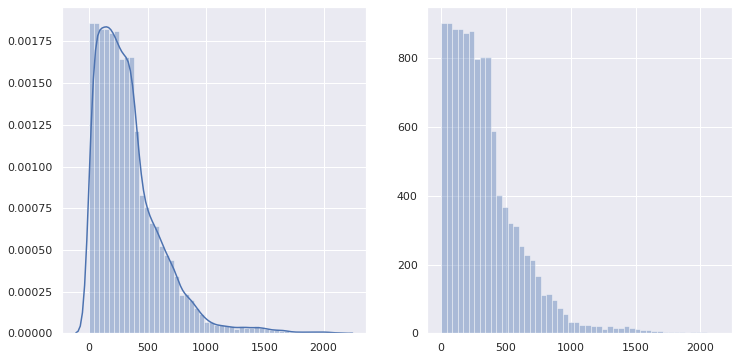

In [38]:
# Getting an idea of the distribution of the RULs in our dataset
sns.set(rc={'figure.figsize':(12,6)})
f = plt.figure()
# Density
ax = f.add_subplot(1, 2, 1)
sns.distplot(y_train)
ax = f.add_subplot(1, 2, 2)
# Counts
sns.distplot(y_train, bins=50, kde=False)

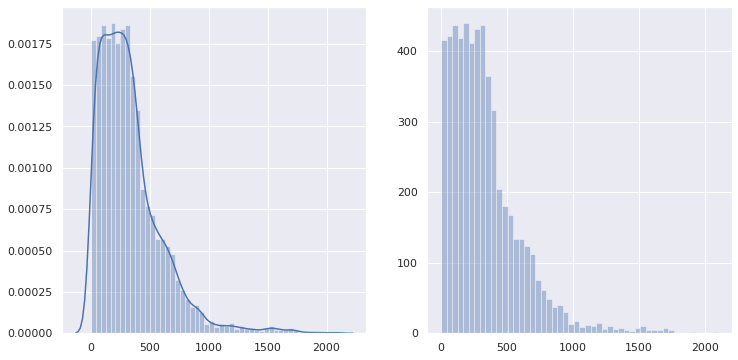

In [39]:
# Getting an idea of the distribution of the RULs in our dataset
sns.set(rc={'figure.figsize':(12,6)})
f = plt.figure()
# Density
ax = f.add_subplot(1, 2, 1)
sns.distplot(y_test)
ax = f.add_subplot(1, 2, 2)
# Counts
sns.distplot(y_test, bins=50, kde=False)

In [40]:
# The target seem skewed, and a log transformatin does not do the trick. 
# An option could be to generate weights for each sample with respect of the "part" of the 
# histogram they are in. 

from sklearn.utils.class_weight import compute_sample_weight
y_train_df = pd.DataFrame(y_train)
hist, bin_edges = np.histogram(y_train_df, bins = 50)
classes = y_train_df.apply(lambda x: pd.cut(x, bin_edges, labels = False, include_lowest = True)).values
sample_weights = compute_sample_weight('balanced', classes)

In [41]:
n_train_samples = X_train.shape[0]

# number of test entries
n_test_samples = X.shape[0]-X_train.shape[0]

# Scale the data
X_train = X_train.reshape(n_train_samples*n_cycles,n_features)
X_test = X_test.reshape(n_test_samples*n_cycles,n_features)

# Best results with a Min-Max scaler with range [-1, 1]
#scaler = StandardScaler()
#scaler = MinMaxScaler(feature_range=(0, 1))
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape(n_train_samples,n_cycles,n_features)
X_test = X_test.reshape(n_test_samples,n_cycles,n_features)

In [50]:
model = Sequential()
model.add(SimpleRNN(64, activation='relu', return_sequences = True, input_shape=(n_cycles, n_features)))
model.add(SimpleRNN(32, activation='relu', return_sequences = True))
model.add(SimpleRNN(16, activation='relu', return_sequences = True))
model.add(SimpleRNN(8, activation='relu', return_sequences = True))
model.add(SimpleRNN(4, activation='relu'))
model.add(Dense(1)) # <---- NOTE: not specifying an activation means that the activation is linear
adam = Adam(learning_rate=0.0005, clipnorm = 0.001)
model.compile(optimizer=adam, loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=400, verbose=1, batch_size = 128, validation_data=(X_test, y_test))

Train on 11361 samples, validate on 5597 samples
Epoch 1/400
11361/11361 [==============================] - 6s 568us/step - loss: 269005.1716 - mae: 351.3112 - val_loss: 84301.2928 - val_mae: 198.2182
Epoch 2/400
11361/11361 [==============================] - 6s 561us/step - loss: 73362.9158 - mae: 200.0213 - val_loss: 61529.2845 - val_mae: 164.8716
Epoch 3/400
11361/11361 [==============================] - 6s 511us/step - loss: 55631.2946 - mae: 162.2792 - val_loss: 47744.1195 - val_mae: 152.8201
Epoch 4/400
11361/11361 [==============================] - 6s 535us/step - loss: 48850.8692 - mae: 146.5064 - val_loss: 39318.0954 - val_mae: 118.6277
Epoch 5/400
11361/11361 [==============================] - 5s 470us/step - loss: 40582.5176 - mae: 125.2782 - val_loss: 34752.2534 - val_mae: 121.0475
Epoch 6/400
11361/11361 [==============================] - 6s 498us/step - loss: 37137.7399 - mae: 118.2718 - val_loss: 49726.8273 - val_mae: 163.1490
Epoch 7/400
11361/11361 [===================

11361/11361 [==============================] - 5s 476us/step - loss: 5277.2938 - mae: 45.8576 - val_loss: 6749.6124 - val_mae: 49.3866
Epoch 111/400
11361/11361 [==============================] - 5s 478us/step - loss: 4894.3844 - mae: 44.1935 - val_loss: 5335.3530 - val_mae: 45.6406
Epoch 112/400
11361/11361 [==============================] - 5s 470us/step - loss: 5638.7150 - mae: 45.6644 - val_loss: 5151.4232 - val_mae: 48.9137
Epoch 113/400
11361/11361 [==============================] - 5s 479us/step - loss: 5373.3368 - mae: 44.3482 - val_loss: 7178.6647 - val_mae: 50.3024
Epoch 114/400
11361/11361 [==============================] - 6s 563us/step - loss: 5952.1220 - mae: 46.7120 - val_loss: 4360.3910 - val_mae: 41.8858
Epoch 115/400
11361/11361 [==============================] - 6s 494us/step - loss: 4629.4145 - mae: 43.1333 - val_loss: 4293.0082 - val_mae: 40.9201
Epoch 116/400
11361/11361 [==============================] - 5s 479us/step - loss: 4498.4699 - mae: 42.9362 - val_loss: 

11361/11361 [==============================] - 5s 479us/step - loss: 3433.0449 - mae: 35.6914 - val_loss: 3394.2589 - val_mae: 36.5401
Epoch 166/400
11361/11361 [==============================] - 5s 477us/step - loss: 2527.8899 - mae: 33.1920 - val_loss: 2892.0491 - val_mae: 34.9945
Epoch 167/400
11361/11361 [==============================] - 6s 485us/step - loss: 2987.4810 - mae: 35.0957 - val_loss: 2803.4579 - val_mae: 34.2475
Epoch 168/400
11361/11361 [==============================] - 6s 484us/step - loss: 2986.9768 - mae: 34.6364 - val_loss: 3067.5286 - val_mae: 34.4565
Epoch 169/400
11361/11361 [==============================] - 6s 484us/step - loss: 2925.4244 - mae: 34.6567 - val_loss: 5233.7915 - val_mae: 39.8856
Epoch 170/400
11361/11361 [==============================] - 5s 470us/step - loss: 2756.7655 - mae: 34.2416 - val_loss: 4145.6304 - val_mae: 38.2182
Epoch 171/400
11361/11361 [==============================] - 5s 466us/step - loss: 3350.6595 - mae: 34.6900 - val_loss: 

11361/11361 [==============================] - 5s 448us/step - loss: 1822.1895 - mae: 28.0544 - val_loss: 1750.7109 - val_mae: 25.3681
Epoch 221/400
11361/11361 [==============================] - 5s 457us/step - loss: 1829.4885 - mae: 28.2154 - val_loss: 2845.5251 - val_mae: 36.2573
Epoch 222/400
11361/11361 [==============================] - 5s 440us/step - loss: 2158.4673 - mae: 29.5404 - val_loss: 3721.1234 - val_mae: 34.0766
Epoch 223/400
11361/11361 [==============================] - 5s 432us/step - loss: 2492.4886 - mae: 30.6087 - val_loss: 2313.6532 - val_mae: 28.5188
Epoch 224/400
11361/11361 [==============================] - 5s 432us/step - loss: 2031.7122 - mae: 29.4188 - val_loss: 1502.7562 - val_mae: 26.6785
Epoch 225/400
11361/11361 [==============================] - 5s 430us/step - loss: 1864.0681 - mae: 28.5009 - val_loss: 2074.2202 - val_mae: 29.0115
Epoch 226/400
11361/11361 [==============================] - 5s 434us/step - loss: 1900.9187 - mae: 28.6632 - val_loss: 

11361/11361 [==============================] - 5s 471us/step - loss: 1375.4286 - mae: 24.5116 - val_loss: 1674.8745 - val_mae: 23.5621
Epoch 276/400
11361/11361 [==============================] - 5s 440us/step - loss: 1298.3834 - mae: 23.7649 - val_loss: 1787.1708 - val_mae: 27.3255
Epoch 277/400
11361/11361 [==============================] - 5s 438us/step - loss: 1260.1436 - mae: 23.8184 - val_loss: 1646.5353 - val_mae: 25.1143
Epoch 278/400
11361/11361 [==============================] - 5s 440us/step - loss: 1226.8133 - mae: 22.7939 - val_loss: 2340.3718 - val_mae: 28.8745
Epoch 279/400
11361/11361 [==============================] - 5s 437us/step - loss: 1313.7926 - mae: 23.7595 - val_loss: 1708.5161 - val_mae: 23.8108
Epoch 280/400
11361/11361 [==============================] - 5s 444us/step - loss: 1912.7198 - mae: 28.8387 - val_loss: 1508.9685 - val_mae: 23.2041
Epoch 281/400
11361/11361 [==============================] - 5s 437us/step - loss: 1430.6145 - mae: 25.1086 - val_loss: 

11361/11361 [==============================] - 6s 518us/step - loss: 955.3325 - mae: 19.9476 - val_loss: 1550.1642 - val_mae: 26.2199
Epoch 386/400
11361/11361 [==============================] - 6s 487us/step - loss: 1362.6362 - mae: 23.6032 - val_loss: 3261.0130 - val_mae: 25.9773
Epoch 387/400
11361/11361 [==============================] - 5s 482us/step - loss: 2040.9809 - mae: 25.1224 - val_loss: 999.2180 - val_mae: 20.5301
Epoch 388/400
11361/11361 [==============================] - 6s 528us/step - loss: 884.0212 - mae: 19.6941 - val_loss: 1103.1099 - val_mae: 20.0311
Epoch 389/400
11361/11361 [==============================] - 6s 503us/step - loss: 1021.1762 - mae: 21.1265 - val_loss: 719.5241 - val_mae: 18.0471
Epoch 390/400
11361/11361 [==============================] - 6s 548us/step - loss: 1144.5889 - mae: 20.3713 - val_loss: 1357.4247 - val_mae: 22.7404
Epoch 391/400
11361/11361 [==============================] - 5s 479us/step - loss: 1383.5346 - mae: 23.5377 - val_loss: 1593

In [51]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_16 (SimpleRNN)    (None, 100, 64)           4608      
_________________________________________________________________
simple_rnn_17 (SimpleRNN)    (None, 100, 32)           3104      
_________________________________________________________________
simple_rnn_18 (SimpleRNN)    (None, 100, 16)           784       
_________________________________________________________________
simple_rnn_19 (SimpleRNN)    (None, 100, 8)            200       
_________________________________________________________________
simple_rnn_20 (SimpleRNN)    (None, 4)                 52        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 8,753
Trainable params: 8,753
Non-trainable params: 0
____________________________________________________

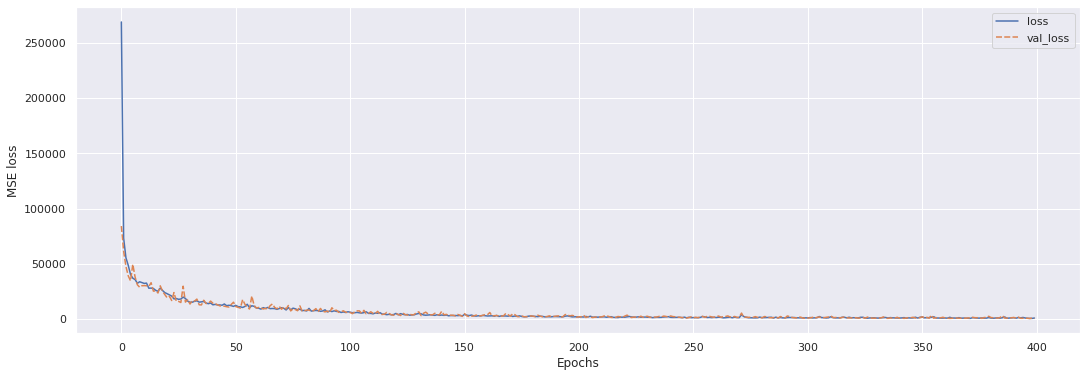

In [66]:
# Graph of the loss function for both train and validation sets
df = pd.DataFrame(history.history['loss'], columns = ['loss'])
df['val_loss'] = history.history['val_loss']

ax = sns.lineplot(data=df)
ax.set(xlabel='Epochs', ylabel='MSE loss')
plt.show()

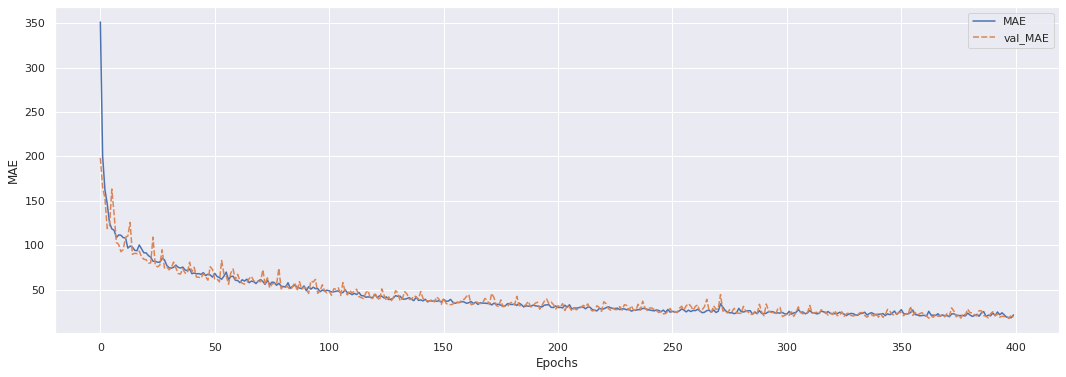

In [53]:
# Graph of the RMSE for both train and validation sets
df = pd.DataFrame(history.history['mae'], columns = ['MAE'])
df['val_MAE'] = history.history['val_mae']

ax = sns.lineplot(data=df)
ax.set(xlabel='Epochs', ylabel='MAE')
plt.show()

In [54]:
scores_train = model.evaluate(X_train, y_train)
scores_test = model.evaluate(X_test, y_test)
print('MSE, MAE train:', scores_train)
print('MSE, MAE test:', scores_test)

5597/5597 [==============================] - 2s 439us/step
MSE, MAE train: [638.4000905942207, 17.451156616210938]
MSE, MAE test: [773.9457912503001, 18.735761642456055]


In [55]:
outputs = model.predict(X_test)

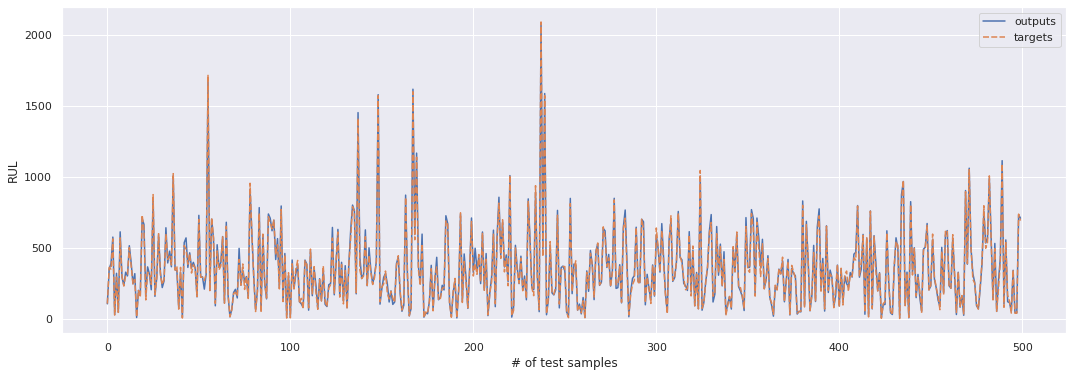

In [64]:
sns.set(rc={'figure.figsize':(18,6)})
df = pd.DataFrame(outputs[0:500], columns = ['outputs'])
df['targets'] = y_test[0:500]
# Graph of the RUL predictions 
ax = sns.lineplot(data=df)
ax.set(xlabel='# of test samples', ylabel='RUL')
plt.show()

In [57]:
# calculate residuals
residuals = [y_test[i]-outputs[i] for i in range(len(outputs))]

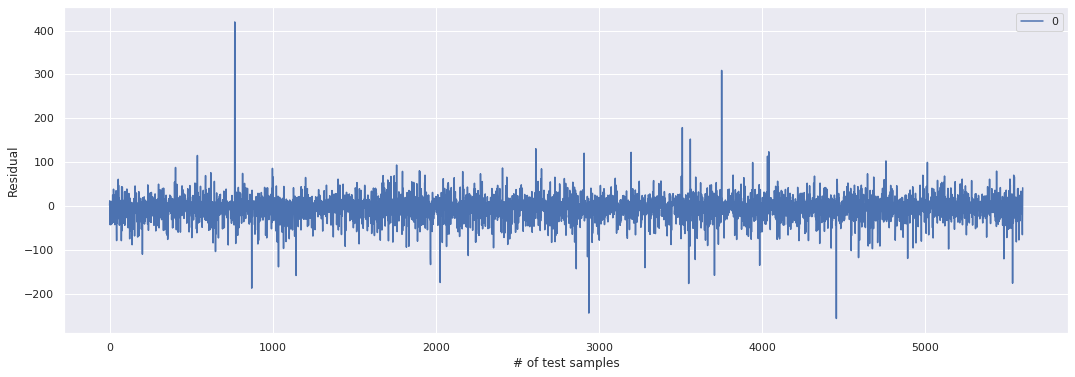

In [58]:
# Plot residuals
residuals = pd.DataFrame(residuals)
ax = sns.lineplot(data=residuals)
ax.set(xlabel='# of test samples', ylabel='Residual')
plt.show()

In [59]:
# summary statistics for residuals
print(residuals.describe())

                 0
count  5597.000000
mean     -4.076342
std      27.522074
min    -256.598877
25%     -16.548950
50%      -1.999260
75%       9.753967
max     419.502930


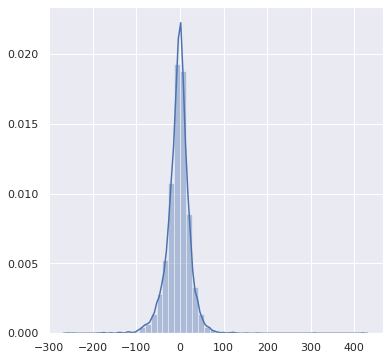

In [60]:
# Plot residuals: check if they are normal-like shaped
sns.set(rc={'figure.figsize':(6,6)})
sns.distplot(residuals, bins=50, kde=True)